In [20]:
import xgt
import os
import pandas as pd

from platform import python_version
print (python_version())

3.7.4


In [21]:
if os.environ.get('https_proxy'):
 del os.environ['https_proxy']
if os.environ.get('http_proxy'):
 del os.environ['http_proxy']

In [22]:
all_attack_events = {
4768 : 'Kerberos authentication ticket was requested (TGT)',
4769 : 'Kerberos service ticket was requested (TGS)',
4770 : 'Kerberos service ticket was renewed',
4774 : 'An account was mapped for logon',
4776 : 'Domain controller attempted to validate credentials',
4624 : 'An account successfully logged on, see Logon Types',
4625 : 'An account failed to logon, see Logon Types',
4634 : 'An account was logged off, see Logon Types',
4647 : 'User initiated logoff',
4648 : 'A logon was attempted using explicit credentials',
4672 : 'Special privileges assigned to a new logon',
4800 : 'The workstation was locked',
4801 : 'The workstation was unlocked',
4802 : 'The screensaver was invoked',
4803 : 'The screensaver was dismissed',
4688 : 'Process start',
4689 : 'Process end',
4608 : 'Windows is starting up',
4609 : 'Windows is shutting down',
1100 : 'Event logging service has shut down'
}

all_attack_event_ids  = all_attack_events.keys()
all_attack_event_desc = all_attack_events.values()
all_attack_event_df   = pd.DataFrame(list(zip(all_attack_event_ids, all_attack_event_desc)), 
               columns =['event_id', 'description']) 

In [23]:
all_attack_logon_types = {
2 : 'Interactive',
5 : 'Service',
9 : 'New Credentials',
3 : 'Network', 
7 : 'Unlock', 
10 : 'Remote Interactive',
4 : 'Batch', 
8 : 'Network Clear Text', 
11 : 'Cached Interactive',
12 : 'Cached Remote-Interactive',
0 : 'Used only by the system account'
}

all_attack_logons = all_attack_logon_types.keys()
all_attack_logon_desc = all_attack_logon_types.values()
all_attack_logon_df = pd.DataFrame(list(zip(all_attack_logons, all_attack_logon_desc)), 
               columns =['logon_type', 'description']) 

In [24]:
conn=xgt.Connection()
conn.server_version

'1.3.0'

In [25]:
try:
  devices = conn.get_vertex_frame('Devices')
except xgt.XgtNameError:
  devices = conn.create_vertex_frame(
      name='Devices',
      schema=[['device', xgt.TEXT]],
      key='device')
devices

In [26]:
try:
  host_events = conn.get_edge_frame('HostEvents')
except xgt.XgtNameError:
  host_events = conn.create_edge_frame(
      name='HostEvents',
      schema=[['epoch_time', xgt.INT],
              ['event_id', xgt.INT],
              ['log_host', xgt.TEXT],
              ['user_name', xgt.TEXT],
              ['domain_name', xgt.TEXT],
              ['logon_id', xgt.INT],
              ['process_name', xgt.TEXT],
              ['process_id', xgt.INT],
              ['parent_process_name', xgt.TEXT],
              ['parent_process_id', xgt.INT]],
           source=devices,
           target=devices,
           source_key='log_host',
           target_key='log_host')
host_events

In [27]:
try:
  auth_events = conn.get_edge_frame('AuthEvents')
except xgt.XgtNameError:
  auth_events = conn.create_edge_frame(
           name='AuthEvents',
           schema = [['epoch_time',xgt.INT],
                     ['event_id',xgt.INT],
                     ['log_host',xgt.TEXT],
                     ['logon_type',xgt.INT],
                     ['logon_type_description',xgt.TEXT],
                     ['user_name',xgt.TEXT],
                     ['domain_name',xgt.TEXT],
                     ['logon_id',xgt.INT],
                     ['subject_user_name',xgt.TEXT],
                     ['subject_domain_name',xgt.TEXT],
                     ['subject_logon_id',xgt.TEXT],
                     ['status',xgt.TEXT],
                     ['src',xgt.TEXT],
                     ['service_name',xgt.TEXT],
                     ['destination',xgt.TEXT],
                     ['authentication_package',xgt.TEXT],
                     ['failure_reason',xgt.TEXT],
                     ['process_name',xgt.TEXT],
                     ['process_id',xgt.INT],
                     ['parent_process_name',xgt.TEXT],
                     ['parent_process_id',xgt.INT]],
            source = 'Devices',
            target = 'Devices',
            source_key = 'src',
            target_key = 'destination')
auth_events

In [28]:
# Utility to print the sizes of data currently in xGT
def print_data_summary():
  print('Devices (vertices): {:,}'.format(devices.num_vertices))
  print('Host events (edges): {:,}'.format(host_events.num_edges))
  print('Authentication events (edges): {:,}'.format(auth_events.num_edges))
  print('Total (edges): {:,}'.format(auth_events.num_edges + host_events.num_edges))
    
print_data_summary()

Devices (vertices): 0
Host events (edges): 0
Authentication events (edges): 0
Total (edges): 0


In [29]:
%%time

# Load the HostEvents event data:
if host_events.num_edges == 0:
    urls = ["xgtd://nvme_data1/data_1v/wls_day-85_1v.csv"]
    host_events.load(urls)
    print_data_summary()

Devices (vertices): 10,324
Host events (edges): 18,637,483
Authentication events (edges): 0
Total (edges): 18,637,483
CPU times: user 44.6 ms, sys: 22.8 ms, total: 67.3 ms
Wall time: 12.4 s


In [30]:
%%time

# Load the AuthEvents event data:
if auth_events.num_edges == 0:
    urls = ["xgtd://nvme_data3/data_2v/wls_day-85_2v.csv"]
    auth_events.load(urls)
    print_data_summary()

Devices (vertices): 12,288
Host events (edges): 18,637,483
Authentication events (edges): 47,790,045
Total (edges): 66,427,528
CPU times: user 55.5 ms, sys: 42.6 ms, total: 98 ms
Wall time: 34.7 s


In [31]:
# Utility function to launch queries and show job number:
#   The job number may be useful if a long-running job needs
#   to be canceled.

def run_query(query, table_name = "answers", drop_answer_table=True, show_query=False):
    if drop_answer_table:
        conn.drop_frame(table_name)
    if query[-1] != '\n':
        query += '\n'
    query += 'INTO {}'.format(table_name)
    if show_query:
        print("Query:\n" + query)
    job = conn.schedule_job(query)
    print("Launched job {}".format(job.id))
    conn.wait_for_job(job)
    table = conn.get_table_frame(table_name)
    return table

In [32]:
%%time
Event_Count_Query_2V = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN r.event_id as event_id, count(*) as event_count 
ORDER BY event_count DESC
""".format('Devices', 'Devices', 'AuthEvents')

print(Event_Count_Query_2V)
answer_table = run_query(Event_Count_Query_2V)
print('Number of answers: {:,}'.format(answer_table.num_rows))

data_2V = answer_table.get_data_pandas()


MATCH (n0:Devices)-[r:AuthEvents]->(n1:Devices)
RETURN r.event_id as event_id, count(*) as event_count 
ORDER BY event_count DESC

Launched job 129
Number of answers: 11
CPU times: user 41.7 ms, sys: 11.9 ms, total: 53.6 ms
Wall time: 2.16 s


In [33]:
%%time
Event_Count_Query_1V = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN r.event_id as event_id, count(*) as event_count
ORDER BY event_count DESC
""".format('Devices', 'Devices', 'HostEvents')

print(Event_Count_Query_1V)
answer_table = run_query(Event_Count_Query_1V)
print('Number of answers: {:,}'.format(answer_table.num_rows))

data_1V = answer_table.get_data_pandas()
data_merge_1V_2V = data_1V.append(data_2V,ignore_index=True)
data_merge_1V_2V.sort_values(by=['event_count'],inplace=True, ascending=False)
data_merge_1V_2V.head()


MATCH (n0:Devices)-[r:HostEvents]->(n1:Devices)
RETURN r.event_id as event_id, count(*) as event_count
ORDER BY event_count DESC

Launched job 153
Number of answers: 9
CPU times: user 23 ms, sys: 6.15 ms, total: 29.2 ms
Wall time: 1.03 s


,event_id,event_count
0,4688,18527129
9,4624,16389671
10,4634,15950203
11,4672,5572526
12,4776,5354657


In [34]:
pd.set_option('display.max_colwidth', -1)
data_events = pd.merge(data_merge_1V_2V, all_attack_event_df, how='inner', on='event_id')
data_events

,event_id,event_count,description
0,4688,18527129,Process start
1,4624,16389671,"An account successfully logged on, see Logon Types"
2,4634,15950203,"An account was logged off, see Logon Types"
3,4672,5572526,Special privileges assigned to a new logon
4,4776,5354657,Domain controller attempted to validate credentials
5,4769,2271788,Kerberos service ticket was requested (TGS)
6,4648,1013302,A logon was attempted using explicit credentials
7,4768,875992,Kerberos authentication ticket was requested (TGT)
8,4625,332510,"An account failed to logon, see Logon Types"
9,4800,38290,The workstation was locked


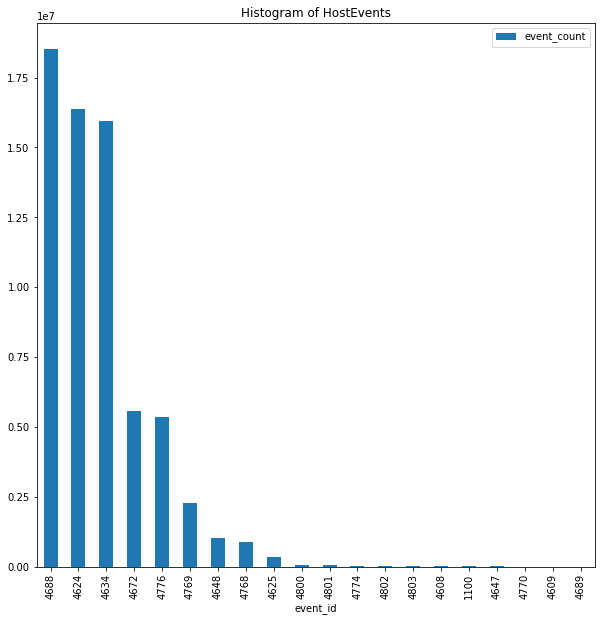

In [35]:
data_events.plot.bar(x='event_id',y='event_count',figsize=(10,10), title='Histogram of HostEvents')

In [36]:
%%time
Logon_Type_Query = """
MATCH (n0:{0})-[r:{2}]->(n1:{1})
RETURN  r.logon_type as logon_type, count(*) as logon_type_count
ORDER BY logon_type_count DESC
""".format('Devices', 'Devices', 'AuthEvents')

print(Logon_Type_Query)
answer_table = run_query(Logon_Type_Query)
print('Number of answers: {:,}'.format(answer_table.num_rows))

data_logon_type = answer_table.get_data_pandas()
data_logon_type.head()


MATCH (n0:Devices)-[r:AuthEvents]->(n1:Devices)
RETURN  r.logon_type as logon_type, count(*) as logon_type_count
ORDER BY logon_type_count DESC

Launched job 168
Number of answers: 10
CPU times: user 81.8 ms, sys: 27.9 ms, total: 110 ms
Wall time: 5.63 s


,logon_type,logon_type_count
0,3,31961748
1,0,15124150
2,5,226616
3,2,191829
4,7,170955


In [37]:
data_logon = pd.merge(data_logon_type, all_attack_logon_df, how='inner', on='logon_type')
data_logon

,logon_type,logon_type_count,description
0,3,31961748,Network
1,0,15124150,Used only by the system account
2,5,226616,Service
3,2,191829,Interactive
4,7,170955,Unlock
5,8,95692,Network Clear Text
6,4,7390,Batch
7,11,5477,Cached Interactive
8,10,3324,Remote Interactive
9,9,2864,New Credentials


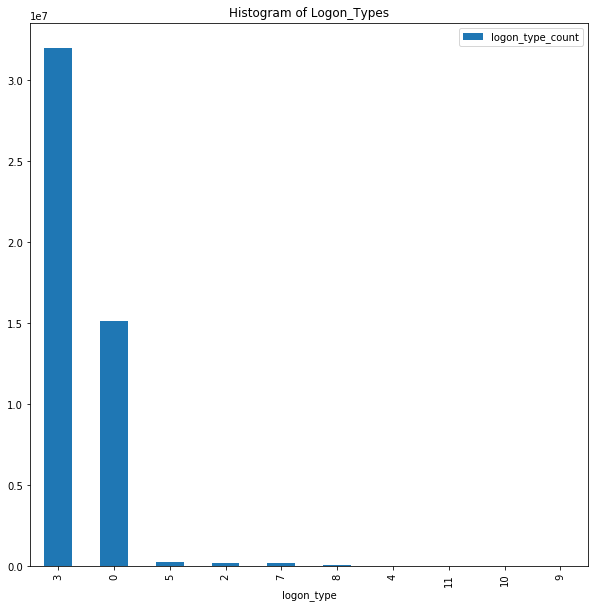

In [38]:
data_logon.plot.bar(x='logon_type',y='logon_type_count',figsize=(10,10), title='Histogram of Logon_Types')